## Analyzing Sequences with Attention Scores

First we must import the relevant files and load in the attention sequences from our previous runs.

In [1]:
# Make necessary imports
import pandas as pd
import numpy as np
from high_attention import kmer2seq, plot_random

# Loading in attention scores from atten.npy
attention_file = "../output/positive_evaulation/atten.npy"
atten_scores = np.load(attention_file)

# multi_head_attention = "../output/positive_evaulation/heads_atten.npy"
# multi_scores = np.load(multi_head_attention)

# # Load in the Sequences from TSV file.
sequences_path = "../data/positive.tsv"
bed_df = pd.read_csv(sequences_path, sep="\t", header=0)
bed_df.columns = ["sequence", "label"]
bed_df["seq"] = bed_df["sequence"].apply(kmer2seq)


#### Loading in Logits for Class Separation

Paired with our positive.tsv, we can perform a variety of analyses with this data.

In [2]:
# Load in the Dataset
predictions_dir = "../output/positive_evaulation/"
yground = np.load(predictions_dir + "labels.npy")
ylogits = np.load(predictions_dir + "pred_results.npy")
ypreds = np.load(predictions_dir + "ypreds_fpr05.npy")

# Threshold to separate PEAS and PEADS from enhancer_explore.ipynb
THRESHOLD = 0.0

# Create the Indices for Each Class to Create Separate fa files for each class. 
peads_condition = np.logical_and(np.logical_and(yground == 0, ypreds != 1),  ylogits[:,2] < 0.0)
peas_condition = np.logical_and(np.logical_and(yground == 0, ypreds != 1), ylogits[:,2] >= 0.0)
active_condition = np.logical_and(yground == 2, ypreds != 1)

peads_indices = np.where(peads_condition)[0]
peas_indices = np.where(peas_condition)[0]
active_indices = np.where(active_condition)[0]

# Take Counts from Enhancer_Explore and Assert that I have the same counts.
assert(len(active_indices) == 7935 and len(peads_indices) == 5841 and len(peas_indices) == 6302)



#### Separate the Data into the Three Classes

In [3]:
# Active Enhancers
active_df = bed_df.iloc[active_indices]
active_atten = atten_scores[active_indices]

# Poised Enhancers Active Dissimilar
peads_df = bed_df.iloc[peads_indices]
peads_atten = atten_scores[peads_indices]

# Poised Enhancers Active Similar
peas_df = bed_df.iloc[peas_indices]
peas_atten = atten_scores[peas_indices]

all_datasets = [active_df, peads_df, peas_df]
all_attens = [active_atten, peads_atten, peas_atten]
all_names = ["AE", "PEADS", "PEAS"]


Here, I am using a panel to show all three plots next to eachother. However, if you are interested in plotting just one of the three, feel free to use `plot_line()` in `high_attention.py` to visualize that attention trend. 

Processing Single Attention Scores.
Saved sequence file for AE.
Processing Single Attention Scores.
Saved sequence file for PEADS.
Processing Single Attention Scores.
Saved sequence file for PEAS.


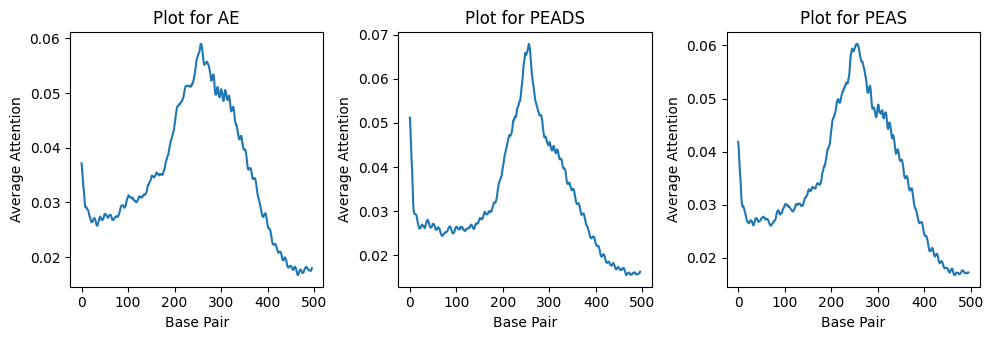

In [4]:
from high_attention import attention_seq, plot_line
import matplotlib.pyplot as plt 

MIN_SEQ_LEN = 8
WINDOW=4

avgs = []
for dataset, atten, name in zip(all_datasets, all_attens, all_names):
    # Run the Sequence Extraction and Visualization
    attention_seq(atten, dataset["seq"], min_len=MIN_SEQ_LEN, 
                  window=WINDOW, name=name,
                  out_dir="../analysis/results/fasta_files/attention_seqs/")
    print("Saved sequence file for {}.".format(name))

    ## <preprocess or split your data>
    avg = np.average(atten, 0)
    avgs.append(avg)


x_values = list(range(len(avgs[0])))
fig, axs = plt.subplots(1, 3, figsize=(10, 3.5))

axs = axs.flatten()

for i, ax in enumerate(axs):
    ax.plot(x_values, avgs[i], linestyle="-")
    ax.set_title(f"Plot for {all_names[i]}")
    ax.set_xlabel("Base Pair")
    ax.set_ylabel("Average Attention")

plt.tight_layout()

# Show the plot
plt.show()

While we certainly see an average trend occurring here, at an individual level, these attention maps look much different. To illustrate this, we include the `plot_random` function that allows you to visualize different random samples provided your attention data. 

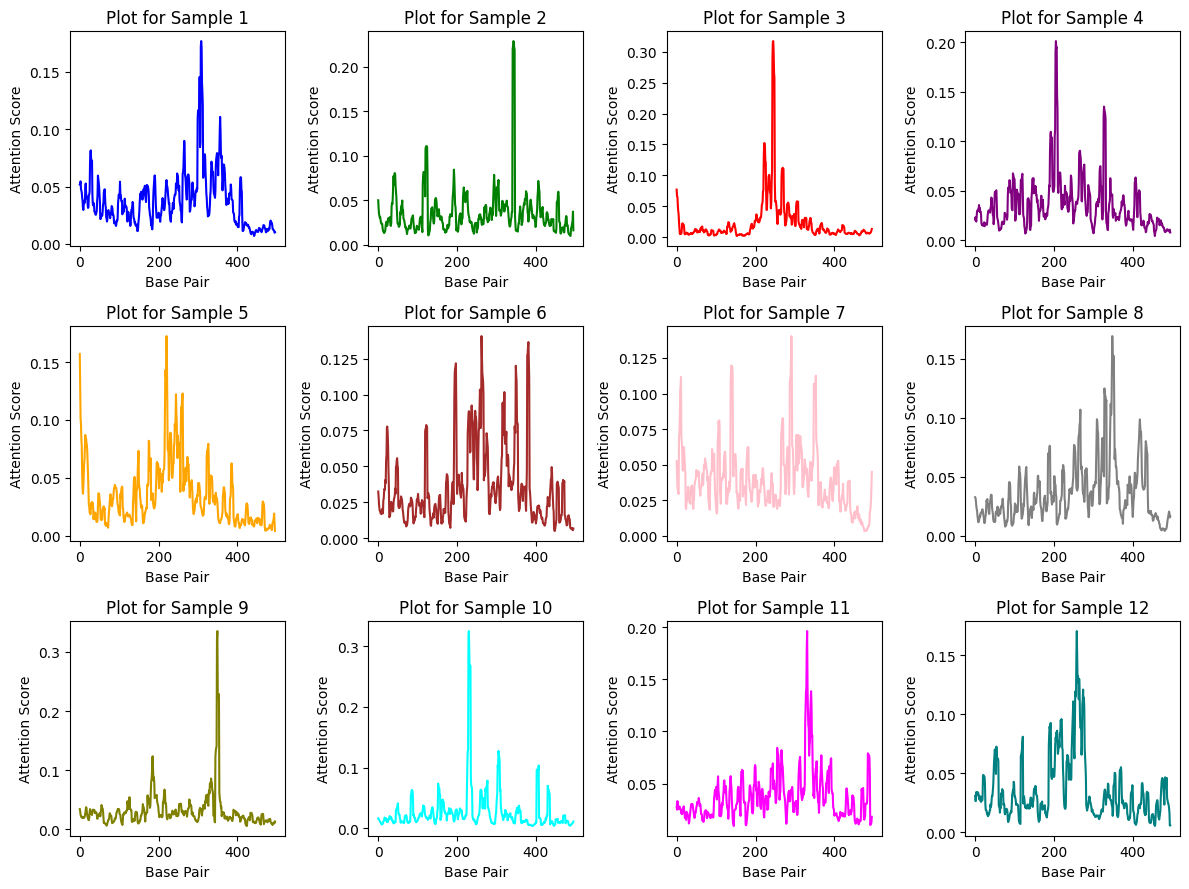

In [18]:
from high_attention import plot_random

plot_random(atten_scores[np.where(ypreds != 1)])

Once you have extracted all of the respective high-attention sequences, you can run FIMO on each of the individual part with your desired set of motifs. An example of usage of this would be the following:

`fimo --o <outdir> <.meme or .streme file>  analysis/results/fasta_files/attention_seqs/AE_high_attention.fa`

### Multi-Head Attention (MHA) Sequence Extraction from High Attention Regions

This functionality works the same. The `attention_seq()` function will automatically detect the three-dimensional multi-head score. We can then plot all twelve heads in a panel using `plot_multi_line()`. 

Processing Multi-Head Attention Scores.


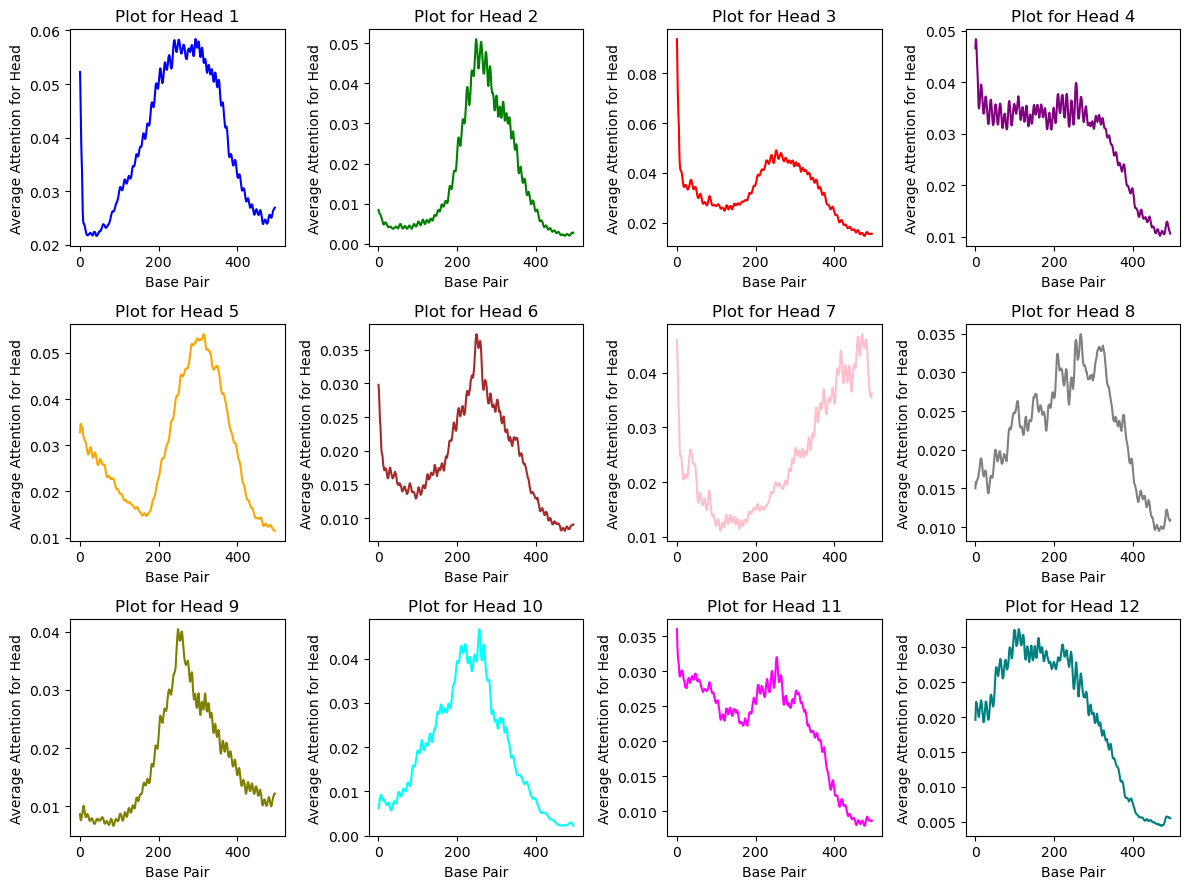

In [8]:
from high_attention import plot_multi_line

# Loading in attention scores from atten.npy. Please note that this currently uses a small sample of MHA scores.
attention_seq(multi_scores, bed_df["seq"], min_len=MIN_SEQ_LEN, out_dir="../analysis/results/fasta_files/multi_atten_seqs/")

multi_average = np.average(multi_scores, 0)
plot_multi_line(multi_average)

## Parsing Attention Regions by Areas of Interest

If you are interested in a specific protein's binding sites and wanted to see the attention landscape at that region you can follow this code. To do this, your positive dataset must have a corresponding BED file that can be read in to the `bed_df` and another BED file containing all binding sites of interest.

In [5]:
columns = ["Chr", "MotifStart", "MotifEnd", "Strand", "Motif_Pvalue", "ChrPos", "EnhancerStart", "EnhancerEnd", "NA1", "NA2", "PosIndex", "Olap_Len"]

# First we Must Load in the BED File.
BEDS="./results/bed_files/"
NAME="CTCF"
ae_motifint = pd.read_csv(filepath_or_buffer=BEDS+NAME+"/ae.bed", sep="\t", header=None)
peads_motifint  = pd.read_csv(filepath_or_buffer=BEDS+NAME+"/peads.bed", sep="\t", header=None)
peas_motifint  = pd.read_csv(filepath_or_buffer=BEDS+NAME+"/peas.bed", sep="\t", header=None)

for bed in [ae_motifint, peads_motifint, peas_motifint]:
    bed.columns = columns

# Ensure that there is ONLY one motif length so that the graph can be properly created.
assert(len(ae_motifint['Olap_Len'].unique()) == len(peads_motifint['Olap_Len'].unique()) == len(peas_motifint['Olap_Len'].unique()) == 1)
motif_len = (peas_motifint['Olap_Len'].unique())[0]

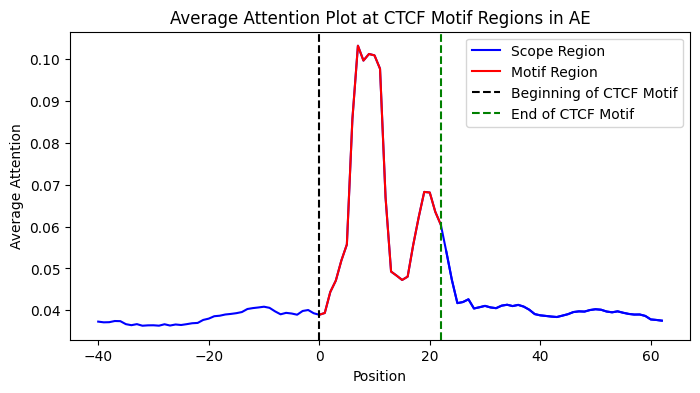

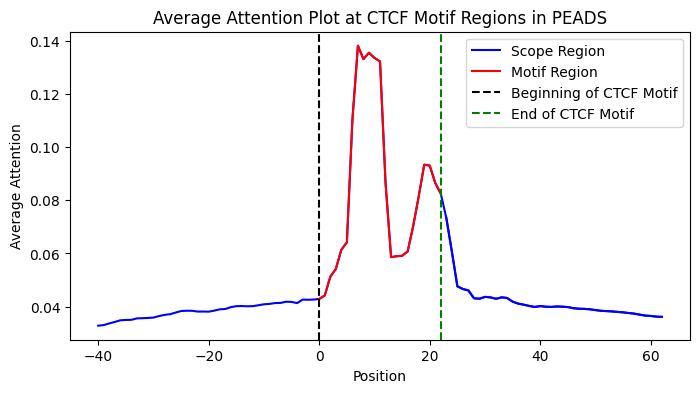

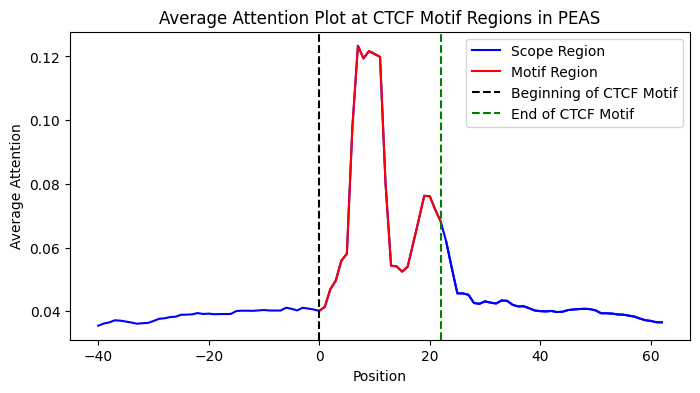

In [6]:
from explore_utils import plot_story, generate_story
for motif_int, name in zip([ae_motifint, peads_motifint, peas_motifint], ["AE", "PEADS", "PEAS"]):
    prelude, story, prologue = generate_story(motif_int, 40, atten_scores)
    plot_story(prelude, story, prologue, "CTCF", name)